# The Explicit Euler Method and Order of Accuracy


The aim of this hands on is to go over the basics of numerical solutions to ODEs using the generic class of finite difference (FD) methods, and specifically using the first example we went over, which is the Explicit Euler method. We will code this simple algorithm up and then use it to solve a first-order ODE and compare with the analytic known solution to check the order of accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

### General statements about the notation and structure

As we discussed in [Lecture 10](https://github.com/UChicagoPhysics/PHYS250/tree/master/Slides/Lecture10), The general form of a first-order differential equation is

$$y^{\prime} = f(x,y)$$

where $y' = \frac{dy}{dx}$ and $f(x, y(x))$ is a given function. The solution of this equation contains an arbitrary constant (the constant of integration). To find this constant, we must know a point on the solution curve; that is, $y$ must be specified at some value of $x$, say, at $x = a$. We write this condition as

$$y(a) = \alpha$$

Any ordinary differential equation of order $n$

$$y^{(n)} = f(x,y,y',...,y^{(n-1)})$$

can always be transformed into n first-order equations. 

As we discussed in class, there is some helpful notation that we can use that will make matrix manipulations more natural later on. 

Using the notation

$$
\begin{align}
  y_0 &= y, \\
  y_1 &= y^{\prime}, \\
  y_2 &= y^{\prime\prime}, \\
  &\vdots \\
  y_{n-1} &= y^{(n-1)}
\end{align}
$$

we can easily write the set of differential equations as

$$F(x,\vec{y}) = \left[\begin{array}{c}
                         y_1 \\
                         y_2 \\
                         \vdots \\
                         f(x,\vec{y})
                       \end{array}
                  \right]$$   

where each element of this vector represents each of the $n$th order differentiual equations of $y$. We can then express the first order differential equations for each of these elements in terms of the following one

$$
\begin{align}
    y_0^{\prime} &= y_1, \\
    y_1^{\prime} &= y_2, \\
    y_2^{\prime} &= y_3, \\
    &\vdots \\
    y_n^{\prime} &= f(x,y_0,y_1,...,y_{n-1})
\end{align}
$$

Consequently, a shift of the index of the matrix is equivalent to a derivative!

Lastly, on much of what we write below, the following two notations will be equivalent:

$$y_{n+1} = y(x_{n+1})$$

### Solutions via the fundamental theorem of calculus

Say we have an ordinary differential equation (ODE) 

$$y' = f(x,y)$$ 

with an initial condition $y(x_0) = y_0$ and we want to solve it numerically. If we know $y(x)$ at a point (or *time*) $x_n$ and want to know what $y$ is at a later time $x_{n+1}$, the [fundametal theorem of calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus) tells us that we find it by integrating $y'$ over the interval,

$$ y_{n+1} = y_n + \int_{x_n}^{x_{n+1}} \! y'(x) \, \mathrm{d}x = y_n + \int_{x_n}^{x_{n+1}} \! f(x,y) \, \mathrm{d}x.$$

As we discussed, the idea behind any ODE solver is to compute the right-hand-side integral for some numerical approximation of $f$. The problem is then computed over a series of steps $n = 1, 2, \dots N$ to give a sequence of points $y_n$ which approximate $y(x)$ to some order of accuracy as a function of the stepsize. The method is **consistent** if the local error (i.e. the error from step $n$ to step $n+1$) goes to zero faster than the stepsize ($x_{n+1} - x_n$) goes to zero.

## The Explicit Euler Method (aka First Order Runge-Kutta).

The first numerical approximations to $f$ we're going to look at are based on Taylor series expansions (surprise!). We know we can expand any infinitely differentiable function $f$ in a Taylor series around the point $x_n$ as 

$$ y_{n+1} = y_{n} + \frac{y'_n}{1!} h + \frac{y''_n}{2!} h^2 + \frac{y'''_n}{3!} h^3 + \dots $$

where $h := x_{n+1} - x_{n}$ is the distance between the points. We'll focus on methods where $h$ is the same for each step (i.e. $\forall n$).

The most basic approximation then, called the **Explicit Euler** method, is to truncate the series at the linear term, discarding quadratic and higher terms. Putting in our ODE $y' = f(x,y)$ gives us the finite difference step

$$
y_{n+1} \approx y_n + hf(x_n, y_n)  + \mathcal{O}(h^2)
$$

and so our sequence of approximation points $y_n$ is calculated as

$$
y_{n+1} = y_n + hf(x_n, y_n).
$$

As we decided to truncate the Taylor expansion after the linear term, the error at each step, called the **local error**, will be on the order of $\mathcal{O}(h^2)$ if $h$ is small and the cumulative effect of these errors over many steps, called the **global error** (that is, after dividing by the step size $h$), will be on the order of $\mathcal{O}(h^1)$.

### Implementing the Method in Python

We'll now define a function to implement the Explicit Euler method for a first-order ODE given an initial condition. Below we'll try it out on a test problem.

In [2]:
def ExplicitEuler(func, y_0, x, args={}):
    """ Explicit Euler approximation to an first-order ODE system with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        x:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array) the approximated solution of the system at each time in t,
              with the initial value y_0 in the first row.
    """

    y = np.zeros([len(x), len(y_0)]) # Initialise the approximation array
    y[0] = y_0                       # Set the initial condition

    # Loop over the time steps
    for i, x_i in enumerate(x[:-1]): 

        h = x[i+1] - x_i                        # size of the step
        y[i+1] = y[i] + h*func(x_i, y[i], args) # Euler step

    return y

#### A note on structure

Notice how I have written up the function. 

I have used an optional argument called `args`. The role that this argument plays is as a *dictionary* of possible coefficients, or *arguments* to pass to the function `func` that the `ExplicitEuler` method will evaluate.

The reason for this is that I want the `ExplicitEuler` function to be able to work on many different kinds of differential equations. we may want to evaluate an exponential function, a hyperbolic function, a polynomial, etc.  But each such function will require its own inputs. The tempting way to do it is to just define `ExplicitEuler` as `ExplicitEuler(h, y_0, exponent)` in the case of an exponential function. But that is a very inefficient way of doing things since the method itself if, of course, quite general.

The `ExplicitEuler` routine should not be concerned with the function parameters. It should do only one thing. Given a function, a set of time steps, and an initial value, it should calculate the next value. *That's it!* 

Also, we may need to evaluate functions with multiple parameters - maybe dozens of them. What then? Would we code up `ExplicitEuler` for every single case? That's too much work!

So, we use an extensible proxy which comes in the form of a dictionary. In this way, the `args` can represent any input you want to give. It is completely agnostic to input type, size etc. The Euler function doesn't touch this argument. These are extra arguments that the actual differential equation will interpret. 

Now, this has to be done carefully. We will have to follow a prescription for defining functions. We will be required to stick to this order for every differential equation function we use with the `ExplicitEuler` function. So, if a function takes a list of arguments, we can safely use this `ExplicitEuler` method unchanged as long as we write the new functions adhering to this rule. 

This is a very powerful technique. You need to use it carefully, but if done right, it lets you create your library of routines and functions that behave very modularly i.e. plug and play as you wish. Their implementation is independent of each other. 

##### Example

This is *exactly* how the ODE solvers that are built upon old FORTRAN routines are constructed. For example:

~~~~
scipy.integrate.odeint
def odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0,
           ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0,
           hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12,
           mxords=5, printmessg=0):
    """
    Integrate a system of ordinary differential equations.
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
        dy/dt = func(y, t0, ...)
    where y can be a vector.
    
    Parameters
    ----------
    func : callable(y, t0, ...)
        Computes the derivative of y at t0.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        A sequence of time points for which to solve for y.  The initial
        value point should be the first element of this sequence.
    args : tuple, optional
        Extra arguments to pass to function.
    """
    
    
    
~~~~

The `odeint` function requires a function `func` that will return the first derivative of each of element in the array. 

In other words, the first element returned is $dy[0]/dt$ and the second element is $dy[1]/dt$, which are both functions of $y[0]$ and $y[1]$. 

You must also provide initial values for $y[0]$ and $y[1]$,  which are placed in
the array $y0$ in this case. 

Finally, the values of the times at which solutions are desired are provided in the array $t$. 

Note that `odeint` returns the values of both the function $y[0]=y$ and its derivative $y[1]=dy/dt$ at each time in an array $y$.  


## Example 1: An Exponential

To see that our Explicit Euler solver actually works, let's take a simple ODE: 

$$y'(x) = ay(x)$$

with intial value $y(0) = 1$ and $a \in \mathbb{C}$. We know the analytic solution of this equation is $y = \mathrm{e}^{ax}$ so we can check the accuracy of the method against this.

Here's that ODE written as a Python function.

In [3]:
def exp(x, y, args):
    """ An exponential function described as a first-order ODE. """
    
    dydx = args['a']*y
    return dydx

I'm using another argument array here and having $a$ passed as an item of the dict `args`. That is a bit overkill here, yes, but for more involved problems you may want to pass more arguments, so this is a tidy way. 

### Solving the Problem

Let's set our initial condition $y_0$ and make our list of discretized steps $x_1, x_2 \dots x_N$.

In [4]:
y_0 = np.array([1.]) # Initial condition

N     = 10 # Num of steps to take
x_max = 5. # Limit of the range to evaluate the function
x     = np.linspace(0., x_max, N+1) # Array of discretized steps

And we need our factor $a$, which we'll just set to $1$ for now.

In [5]:
solve_args = {'a':1}

Now we're ready to solve using the Explicit Eulder integrator we wrote, and we'll plot the results alongside the known analytic result $y = \mathrm{e}^{x}$.

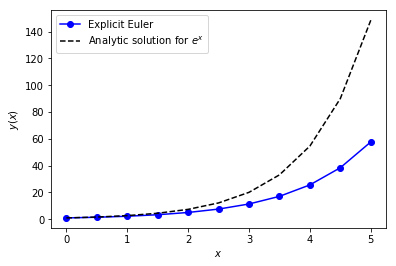

In [6]:
y = ExplicitEuler(exp, y_0, x, solve_args) # Solve the ODE with Explicit Euler

plt.plot(x, y[:,0], 'b-o', label='Explicit Euler')
plt.plot(x, np.exp(solve_args['a']*x), 'k--', label='Analytic solution for $e^{x}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.legend(loc=2)

plt.show()

OK, so with $N = 10$ steps the numerical solution (blue dots) follows the known exponential behaviour, but is underestimating the known result (black dashed line). 

We know from the Taylor series truncation we made that the error in the approximation scales with the stepsize, so if we want a more accurate solution the first thing to do is to make the stepsize $h$ smaller. Let's try that.

## Checking Accuracy

To see that the accuracy improves with smaller $h$, we'll solve the system for different numbers of steps: $N = 5, 10, 20, 40$ (corresponding to $h = 1, \frac{1}{2}, \tfrac{1}{4}, \tfrac{1}{8}$).

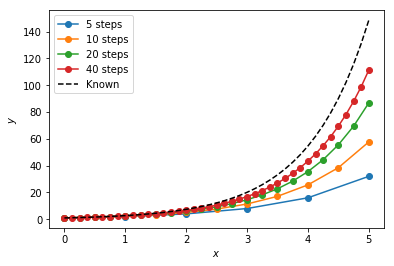

In [7]:
for N in [5, 10, 20, 40]:

    x = np.linspace(0., x_max, N+1) # Time steps
    y = ExplicitEuler(exp, y_0, x, solve_args)
    plt.plot(x, y, '-o', label='%d steps'%N) 
    
plt.plot(x, np.exp(solve_args['a']*x), 'k--', label='Known')

plt.xlabel(r'$x$'), plt.ylabel(r'$y$')
plt.legend(loc=2)

This looks good: the solution is converging on the known result as we increase the number of steps, which tells us that the method is consistent, as any useful method must be. 

We can check that the order of the approximation is indeed $\mathcal{O}(h^1)$ by plotting a function of the global error at $x=5$, given by $| \, y_N - e^5 \, |$, over a large range of stepsizes $h$.

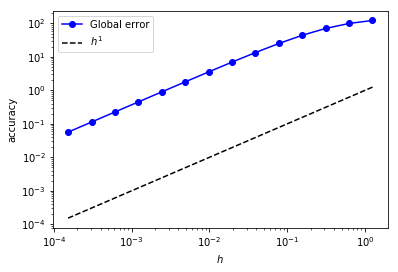

In [8]:
max_N = 16                     # Number of points at which to check the error
N     = 2**np.arange(2, max_N) # Array of those points: N = 2, 4, 8, ..., 2^max_N

order_check = 1 # for visual check of the order of accuracy

y_end    = np.zeros(len(N)) # array to fill with the final values
stepsize = np.zeros(len(N)) # array to fill with the stepsizes

for i, N_i in enumerate(N): # loop over different numbers of steps

    x = np.linspace(0., x_max, N_i+1)
    y_end[i] = ExplicitEuler(exp, y_0, x, solve_args)[-1]
    
    stepsize[i] = x_max/N_i
    
plt.loglog(stepsize, abs(y_end - np.exp(solve_args['a']*x_max)), 'b-o', label='Global error')
plt.loglog(stepsize, stepsize**order_check,'k--', label=r'$h^1$')
plt.xlabel(r'$h$')
plt.ylabel('accuracy')
plt.legend(loc=2)

We see that the slope is constant below $h \approx 0.1$, which tells us that the order is constant. 

We could find that order formally by fitting this logarithm, but it's good enough for now to compare the global error with the function $h^1$ (black dashed line). 

That the slopes are the same indicates visually that the method is $\mathcal{O}(h^1)$. (Try comparing with $h^2$ by changing `order_check` in the code above to $2$.)